## Create Amazon type ArcGIS Cloud Storage (ACS) connection files for NASA Earthdata STAC

### You will need a NASA Earthdata account to use this code. You can create a free account at https://www.earthdata.nasa.gov/data/earthdata-login
##### This notebook creates ACS connections using "Amazon" Service Provider option and support requires ArcGIS Pro minimum version of 3.5.0 for wotk with NASA Earthdata. Using Amazon provider will produce s3:// protocol links when used with a NASA Earthdata STAC connection in ArcGIS Pro. This access method with NASA Earthdata requires ArcGIS Pro to be running on virtual machine in AWS us-west-2 (Oregon) region. This ACS connection type is ideal for working with large datasets or running analysis at large scale.
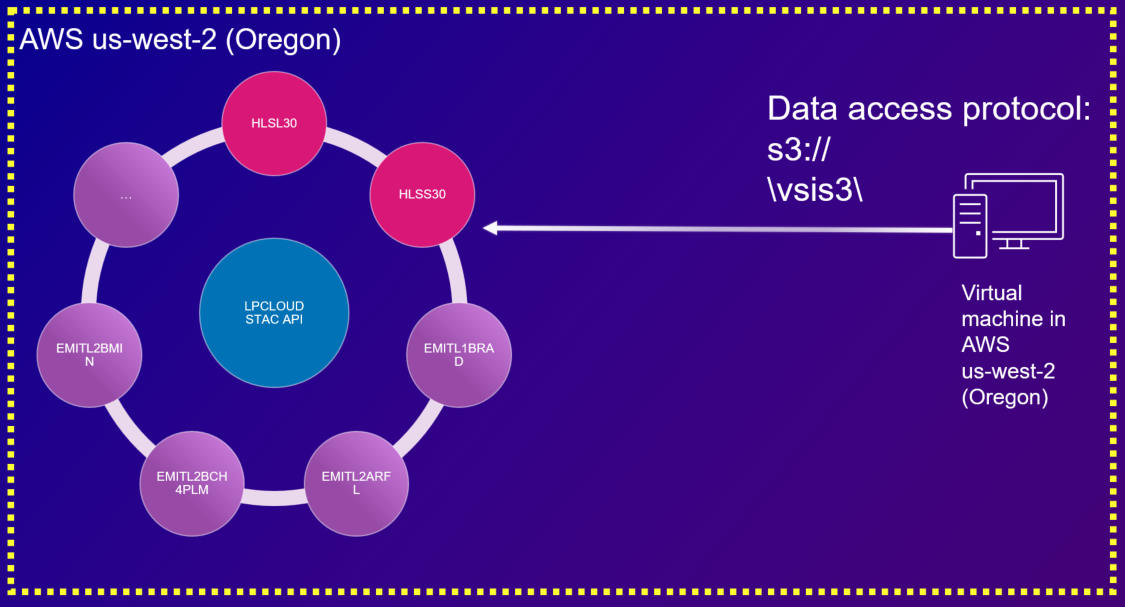
##### For use on a machine that is not in AWS us-west-2 (Oregon) the "Web" Service Provider method (separate notebook in this repository) is required.

## Enter your NASA Earthdata credentials

In [ ]:
import getpass

org_url = "https://www.arcgis.com"
earthdata_un = input("Enter your NASA Earthdata username: ")
earthdata_pw = getpass.getpass("Enter your NASA Earthdata password: ")

## Define functions that process the STAC metadata

In [ ]:
import arcpy
import json
import requests
import os
from urllib.parse import urlparse
from pathlib import Path

### Gets links to STAC collections

In [ ]:
def get_collection_paginated(url):
    collections = []
    while url:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        collections.extend(data.get('collections', []))
        # Find the next page link
        next_link = None
        for link in data.get('links', []):
            if link.get('rel') == 'next':
                next_link = link.get('href')
                break
        url = next_link
    return collections

### Parses the s3 path to extract bucket and folder

In [ ]:
def extract_domain_and_folder_from_s3_href(href):
    parsed_url = urlparse(href)
    path = parsed_url.path.strip('/')
    domain = parsed_url.netloc
    return domain, path

### Creates an ACS connection file

In [ ]:
def createACS(user, passwd, outputfolder, filename, bucketName, folder, s3_credentials):
    arcTokenService = "ARC_TOKEN_SERVICE_API " + s3_credentials
    configOptions = arcTokenService + ";ARC_TOKEN_OPTION_NAME AWS_SESSION_TOKEN;GDAL_DISABLE_READDIR_ON_OPEN EMPTY_DIR;ARC_DEEP_CRAWL NO"
    print(f"creating acs - {outputfolder}{filename}| Bucketname: {bucketName}| Folder: {folder}| TokenService: {s3_credentials}")
    
    arcpy.management.CreateCloudStorageConnectionFile(
        out_folder_path=outputfolder,
        out_name=filename,
        service_provider="AMAZON",
        bucket_name=bucketName,
        access_key_id=user,
        secret_access_key=passwd,
        region="us-west-2",
        end_point="s3-us-west-2.amazonaws.com",
        config_options=configOptions,
        folder=folder,
        authentication=""
    )

### Creates ACS connection files for each Collection in a NASA Earthdata Catalog

In [ ]:
def createAcsForOneCollection(collectionUrl, user, passwd, outputfolder):
    #Step 1: Fetch all collections from the provider's /collections endpoint
    all_collections = get_collection_paginated(collectionUrl + "/collections")
    used_filenames = set()
    
    # Step 2: Display all the collections present within the selected collection
    print("Collections found:")
    for collection in all_collections:
        print(f"- {collection['id']}")
        
    # Step 3: Iterate through each collection to process it
    for collection in all_collections:
        collection_id = collection['id']
        s3_credentials = ""
        # Find s3_credentials and s3 data assets
        for asset_key, asset in collection.get('assets', {}).items():
            if asset_key == "s3_credentials" and not s3_credentials:
                s3_credentials = asset['href']
        for asset_key, asset in collection.get('assets', {}).items():
            if 'data' in asset.get('roles', []) and asset.get('href', '').startswith('s3://'):
                href = asset['href']
                if "public" not in href:
                    bucketname, folder = extract_domain_and_folder_from_s3_href(href)
                    base_filename = collection_id.replace('/', '_').replace('.', '_')
                    filename = base_filename
                    counter = 1
                    # To ensure filename is unique in this run
                    while filename in used_filenames:
                        filename = f"{base_filename}_{counter}"
                        counter += 1
                    used_filenames.add(filename)
                    createACS(user, passwd, outputfolder, filename, bucketname, folder, s3_credentials)

### Creates ACS connection files for each Collection in the entire NASA Earthdata Catalog 

In [ ]:
def createAcsForFullStac(stacurl, user, passwd, outputfolder):
    # Step 1: Fetch the root catalog
    response = requests.get(stacurl)
    response.raise_for_status()
    data = response.json()

    # Step 2: Extract all "child" links
    child_links = [link['href'] for link in data.get('links', []) if link.get('rel') == 'child']

    used_filenames = set()
    # Step 3: For each child, process its collections
    for child_url in child_links:
        all_collections = get_collection_paginated(child_url + "/collections")
        for collection in all_collections:
            collection_id = collection['id']
            s3_credentials = ""
            for asset_key, asset in collection.get('assets', {}).items():
                if asset_key == "s3_credentials" and not s3_credentials:
                    s3_credentials = asset['href']
            for asset_key, asset in collection.get('assets', {}).items():
                if 'data' in asset.get('roles', []) and asset.get('href', '').startswith('s3://'):
                    href = asset['href']
                    if "public" not in href:
                        bucketname, folder = extract_domain_and_folder_from_s3_href(href)
                        base_filename = collection_id.replace('/', '_').replace('.', '_')
                        filename = base_filename
                        counter = 1
                        while filename in used_filenames:
                            filename = f"{base_filename}_{counter}"
                            counter += 1
                        used_filenames.add(filename)
                        createACS(user, passwd, outputfolder, filename, bucketname, folder, s3_credentials)


## Creates ACS connection files for the LPCLOUD STAC Catalog

In [ ]:
%%time

url = "https://cmr.earthdata.nasa.gov/stac/LPCLOUD"
acs_folder = r"c:\acsfiles\NASAEarthdata\Amazon\LPCLOUD"
# Create parent directories if they don't exist
file_path = Path(acs_folder)
file_path.mkdir(parents=True, exist_ok=True)
createAcsForOneCollection(url, earthdata_un, earthdata_pw, acs_folder)

## Creates ACS connection files for a user-specified Earthdata Catalog

In [ ]:
%%time

url = input("Enter the URI for a specific NASA Earthdata Catalog: e.g. https://cmr.earthdata.nasa.gov/stac/LAADS")
acsfolder = input("Enter the directory for creating ACS connection files: e.g. C:\\acsfiles\\NASAEarthdata\\Amazon\\LAADS")
# Create parent directories if they don't exist
file_path = Path(acs_folder)
file_path.mkdir(parents=True, exist_ok=True)

createAcsForOneCollection(url, earthdata_un, earthdata_pw, acs_folder)

## Creates ACS connection files for the entire Earthdata CMR STAC

In [ ]:
%%time

url = "https://cmr.earthdata.nasa.gov/stac"
acs_folder = input("Enter the directory for creating all Earthdata ACS connection files: e.g. C:\\acsfiles\\NASAEarthdata\\Amazon\\CMR")
# Create parent directories if they don't exist
file_path = Path(acs_folder)
file_path.mkdir(parents=True, exist_ok=True)
createAcsForFullStac(url, earthdata_un, earthdata_pw, acs_folder)